# Deterministic SIR model and relation to enzyme kinetics

The SIR model contains 3 species:
- Susceptible is the general healthy population
- Infected is the infected population
- Removed is the part of the population who have either perished or have recovered with full immunity

The model depends on two parameters, the rate of infection $\beta$, and the rate of recovery $\gamma$.
$$S \stackrel{\beta}\rightarrow I \stackrel{\gamma}\rightarrow R$$

This is similar to the following simple model of enzyme catalysis involving enzyme, substrate  and product, when substrate dissociation (reverse $k_1$) is slow:
$$Enz+Sub  \stackrel{k_1}\rightarrow ES \stackrel{k_2}\rightarrow Enz + Prod$$

In fact, the infection rate ($\beta$) of individuals and the binding rate of substrate to enzyme ($k_1$) are both second-order rate parameters dependent on two variables (S and I; Enz and Sub), thus both models involve a second-order process followed by a first-order process, and can be readily written in the form of ordinary differential equations.

Below, numerical integration will be used to simulate both systems over time.

In [1]:
%pylab inline
import scipy.integrate

Populating the interactive namespace from numpy and matplotlib


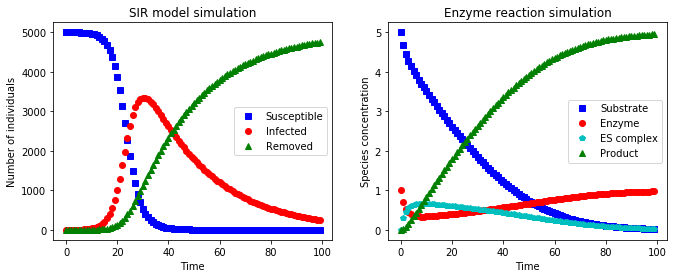

In [2]:
# SIR
beta=0.00008; gamma=0.04; S0=5000; I0=1; R0=0; species=(S0, I0, R0)
def model1(species,t):
    Susceptible = -beta * species[0] * species[1]
    Infected = beta * species[0] * species[1] - gamma * species[1]
    Removed = gamma * species[1]
    return [Susceptible,Infected,Removed]

sol1 = scipy.integrate.odeint(model1,species,np.arange(0,100,1))

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11,4),sharex=True)
ax1.plot(sol1[:,0], 'bs', label='Susceptible');
ax1.plot(sol1[:,1], 'ro', label='Infected');
ax1.plot(sol1[:,2], 'g^', label='Removed');
ax1.legend(loc=0); ax1.set_title('SIR model simulation'); ax1.set_xlabel('Time'); ax1.set_ylabel('Number of individuals')

# Enzyme kinetics
k1=0.08; k2=0.15; S0=5; E0=1; ES0=0; P0=0; species=(S0, E0, ES0, P0)
def model2(species,t):
    Sub = -k1 * species[0] * species[1]
    Enz = -k1 * species[0] * species[1] + k2 * species[2]
    ES = k1 * species[0] * species[1] - k2 * species[2]
    Prod = k2 * species[2]
    return [Sub,Enz,ES,Prod]

sol2 = scipy.integrate.odeint(model2,species,np.arange(0,100,1))

ax2.plot(sol2[:,0], 'bs', label='Substrate');
ax2.plot(sol2[:,1], 'ro', label='Enzyme');
ax2.plot(sol2[:,2], 'cp', label='ES complex');
ax2.plot(sol2[:,3], 'g^', label='Product');
ax2.legend(loc=0); ax2.set_title('Enzyme reaction simulation'); ax2.set_xlabel('Time'); ax2.set_ylabel('Species concentration');

Using these ODE models, parameters can be readily estimated via non-linear least squares fitting etc

# Stochastic SIR model using Gillespie's algorithm

When dealing with biochemical systems involving a small number of molecules, randomness becomes ever more important. Instead of using differential equations, one alternative is therefore to use Markovian processes to simulate the system. One of the best-known algorithms for the simulation of chemical reactions using this approach is Gillespie's algorithm.

In epidemiological modelling, stochasticity is of special importance given that at the start of an outbreak only a few individuals/places are affected. Gillespie's algorithm can be used to simulate these dynamics in an identical way to chemical kinetics, assuming that the same conditions apply, eg. populations are homogeneous and rapidly mixing. 

Markov Chains are not only useful for simulating stochastic temporal models, but also for estimating posterior probability distribution when applying Bayesian statistics.

Below, Gillespie's algorithm will be applied to simulate the SIR model ten times using the same parameters as before.

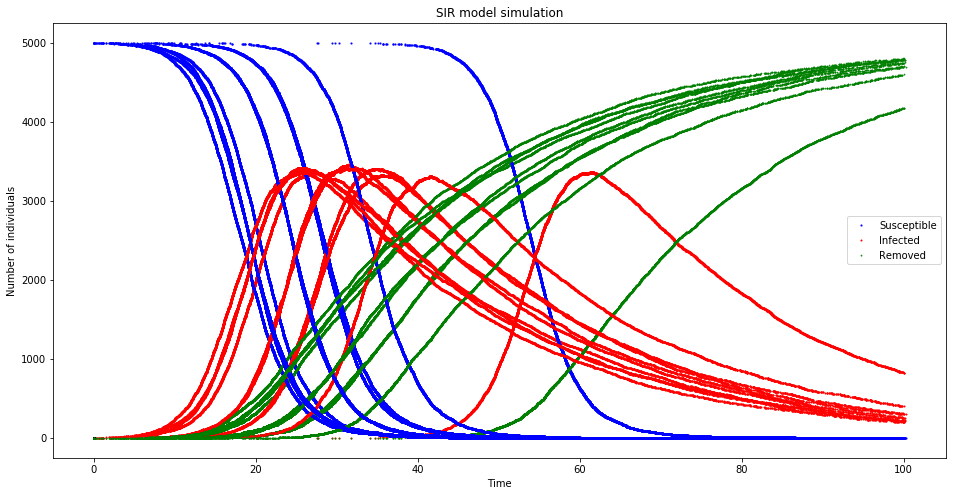

In [244]:
# set up stoichiometry matrix for SIR model, ie. the numeric change in species for each step
#                 S  I R
stoich=np.array([[-1,1,0], # infection step
                 [0,-1,1]]) # recovery step

# initialisation of parameters and species concentrations
beta=0.00008
gamma=0.04
S0=5000
I0=1
R0=0

# set duration/counters
tmax=100
nmax=10000
simulations=10

# set storage arrays
store_t=np.zeros((simulations,nmax, 1))
store_species=np.zeros((simulations,nmax, 3)) # 3 is number of species
store_species[:,0]=[S0,I0,R0]

# produce stochastic evolution
def next_time_reaction(a0,a):
    #get next time
    rands=np.random.random(2)
    T=(1/a0)*np.log(1/rands[0])

    #get next reaction. instead of drawing from a discrete distribution using scipy,
    #this much faster version is adapted from: https://github.com/karinsasaki/gillespie-algorithm-python
    mu=0
    N=rands[1]*a0 - a[mu]
    while N > 0:
        mu=mu+1
        N=N-a[mu]
    return T, mu

#update states and save intermediate results
for k in range(simulations):
    t=0
    n=0
    while t < tmax:
        a=np.array([beta*store_species[k,n,0]*store_species[k,n,1], # rate infection step
                    gamma*store_species[k,n,1]])                  # rate recovery step
        a0=sum(a)
        
        # calculate evolution
        next_time, next_reaction = next_time_reaction(a0,a)
        
        # advance system
        t=store_t[k,n]+next_time
        store_t[k,n+1]=t
        store_species[k,n+1]=store_species[k,n]+stoich[next_reaction]
        n=n+1
        
# print(shape(store_t),shape(store_species))
# print(store_t,store_species)

fig, ax = plt.subplots(figsize=(16,8));
[
    [ax.plot(store_t[i],store_species[i,:,0], 'bs', markersize=1),
  ax.plot(store_t[i],store_species[i,:,1], 'ro', markersize=1),
  ax.plot(store_t[i],store_species[i,:,2], 'g^', markersize=1)
    ] for i in range(simulations)];
ax.legend(['Susceptible','Infected','Removed',],loc=0);
ax.set_title('SIR model simulation');
ax.set_xlabel('Time');
ax.set_ylabel('Number of individuals');

Stochastic integration reveals that the course of the epidemic varies greatly even when considering identical parameters. For example: Most often, the maximum number of Infected usually occurs between day 20-40 whereas, in one case, it only occurs after 60 days.